## Installations

## Imports

In [45]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns  
from datetime import datetime, timezone
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

filterwarnings("ignore")



In [2]:
load_dotenv(find_dotenv())

PROJECT_PATH=os.getenv('PROJECT_PATH')
MAX_T=int(os.getenv('MAX_T'))



## Methods

In [3]:
def read_file(file):
    df=pd.read_csv(file)

    return df


def get_all_players(df):
    all_whites=list(set(sorted(df["White"])))
    all_whites=sorted(all_whites)
    all_black=list(set(sorted(df["Black"])))
    all_black=sorted(all_black)
    all_players=list(set(all_whites+all_black))
    return all_players
def get_events_for_player(df,player):
    return Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Event"]))
def get_games_for_player(df,player):
    return df[(df["White"]==player)|(df["Black"]==player)]

def get_years_for_player(df,player):
    return dict(Counter(list(df[(df["White"]==player)|(df["Black"]==player)]["Year"])))
def get_years_for_player_game(df,player,game):
    return dict(Counter(list(df[((df["White"]==player)|(df["Black"]==player))&(df["Event"]==game)]["Year"])))
def get_players(df):
    w=list(df["White"])
    b=list(df["Black"])
    all=list(set((w+b)))
    return all

def get_games_for_player(df,player):
    player_black_df=df[df["Black"]==player]
    player_black_df=player_black_df[["UTCDate","BlackElo","UTCTime"]]
    player_black_df.rename(columns={'BlackElo':'Elo'},inplace=True)

    player_white_df=df[df["White"]==player]
    player_white_df=player_white_df[["UTCDate","WhiteElo","UTCTime"]]
    player_white_df.rename(columns={'WhiteElo':'Elo'},inplace=True)

    return pd.concat([player_black_df,player_white_df]).sort_values(by='UTCDate')


def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp

def get_players_atleast_x_games_type(x,game_type,df):

    df_c=(df[df["Event"]==" Blitz "])
    w=dict(df_c["White"].value_counts())
    b=dict(df_c["Black"].value_counts())
    all={}
    all=w
    for k,v in b.items():
        all[k]=all.get(k,0)+v
    h=[]
    for k,v in w.items():
        if v>200:
            h.append(k)
    len(h)

    #
    df=df[(df["White"].isin(h))|(df["Black"].isin(h))]

    #
    df1=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(h))&(~df["Black"].isin(h))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(h))&(df["Black"].isin(h))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(h))&(df["Black"].isin(h))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
    return df

def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['label'], test['label']
    X_train, X_test = train.drop('label', axis=1), test.drop('label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("-"*100)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    print("-"*100)
    
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }
    
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])

    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    # Create a heatmap of the summary
    plt.figure(figsize= (10,10))
    sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
    plt.show()
    

## Baseline classification(just use points no features)

In [4]:
with open(f"{PROJECT_PATH}/models/fics/player_series_labels_150_euclidean.pkl", 'rb') as f:
    player_series_labels=pickle.load(f)
players=set(player_series_labels.keys())

In [5]:
data_dict={
    "label":[]
}
for p in player_series_labels:
    num_games=len(player_series_labels[p]['games'])
    data_dict["label"].append(int(player_series_labels[p]["label"][0]==1))
    for i in range(0,min(num_games,MAX_T)):
        data_dict["t="+str(i)+""]=data_dict.get("t="+str(i),[])
        data_dict["t="+str(i)+""].append(player_series_labels[p]['games'][i])

df=pd.DataFrame.from_dict(data_dict)

In [6]:
df

,label,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,...,t=40,t=41,t=42,t=43,t=44,t=45,t=46,t=47,t=48,t=49
0,0,1783,1776,1785,1779,1790,1795,1792,1791,1789,...,1776,1785,1793,1781,1782,1768,1760,1756,1742,1725
1,1,1513,1500,1514,1504,1492,1491,1485,1478,1491,...,1554,1562,1557,1550,1558,1568,1567,1579,1571,1582
2,0,2220,2225,2229,2233,2237,2241,2245,2241,2245,...,2230,2227,2217,2207,2206,2212,2200,2206,2211,2216
3,1,1488,1512,1528,1541,1551,1518,1523,1500,1528,...,1538,1558,1563,1583,1598,1604,1615,1560,1575,1592
4,0,1551,1558,1565,1572,1578,1584,1589,1594,1583,...,1613,1607,1601,1595,1589,1584,1595,1589,1584,1579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,1,1356,1363,1371,1363,1357,1365,1371,1362,1362,...,1347,1337,1336,1345,1354,1361,1354,1345,1353,1362
5929,1,1577,1582,1569,1557,1545,1542,1551,1559,1561,...,1622,1613,1620,1628,1624,1623,1628,1639,1644,1647
5930,0,1181,1175,1174,1172,1165,1160,1147,1145,1162,...,1072,1073,1056,1041,1028,1016,1020,1009,999,990
5931,1,1666,1657,1649,1641,1636,1630,1622,1616,1626,...,1616,1626,1621,1616,1609,1603,1597,1607,1617,1625


In [7]:
models=[]

#### logistic regression

----------------------------------------------------------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6967144060657119
roc_auc_score: 0.601327002439487
precision_score: 0.5378151260504201
f1_score: 0.41558441558441556
----------------------------------------------------------------------------------------------------


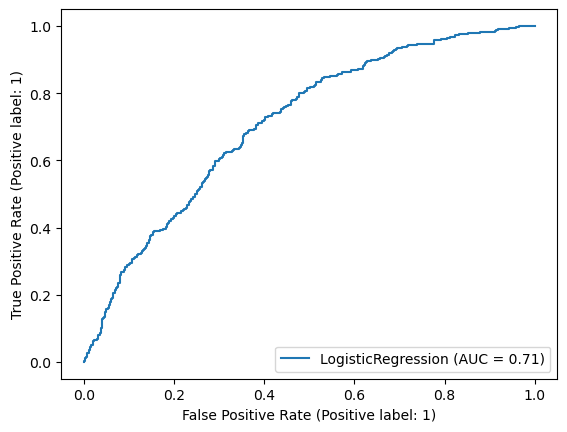

In [8]:
from sklearn.linear_model import LogisticRegression
models.append(classify(df,0.2,LogisticRegression(),"logistic regression"))

#### Support vector machines

----------------------------------------------------------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6697556866048863
roc_auc_score: 0.5246584556420654
precision_score: 0.5849056603773585
f1_score: 0.13656387665198239
----------------------------------------------------------------------------------------------------


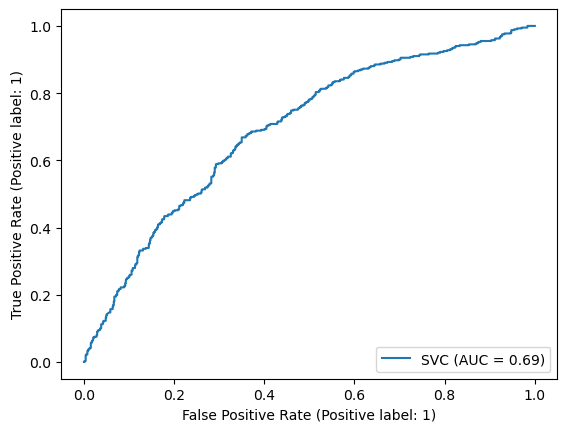

In [9]:
from sklearn.svm import SVC
models.append(classify(df,0.2,SVC(probability =True),"Support vector machine"))

#### Random Forrest

----------------------------------------------------------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.6655433866891323
roc_auc_score: 0.5912224869977517
precision_score: 0.5756302521008403
f1_score: 0.4083457526080477
----------------------------------------------------------------------------------------------------


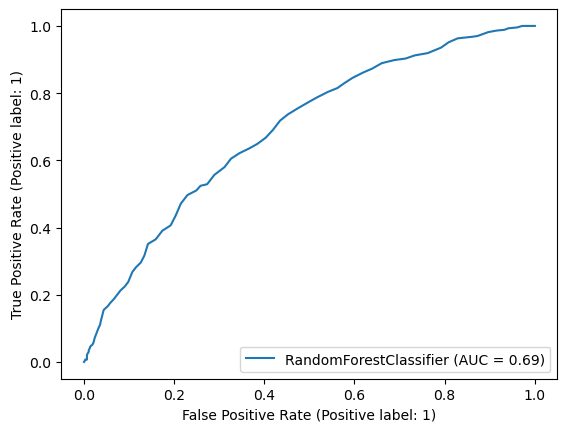

In [10]:
from sklearn.ensemble import RandomForestClassifier 
models.append(classify(df,0.2,RandomForestClassifier(n_estimators=100, random_state=42),"basic random forrest"))

#### Decision Tree

----------------------------------------------------------------------------------------------------
Model name: decision tree
accuracy_score: 0.6082561078348778
roc_auc_score: 0.5680497475451476
precision_score: 0.4469135802469136
f1_score: 0.437726723095526
----------------------------------------------------------------------------------------------------


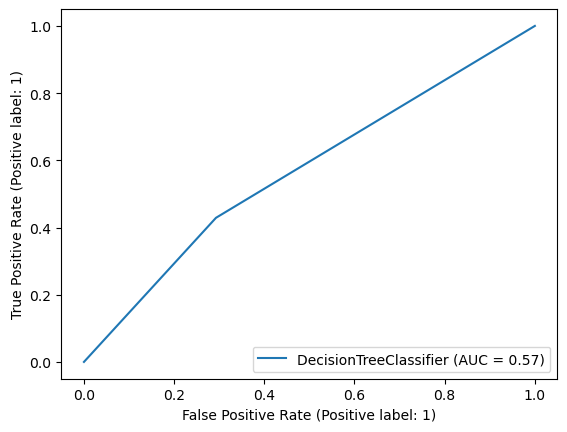

In [11]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
models.append(classify(df,0.2,DecisionTreeClassifier(random_state=42),"decision tree"))

#### Gaussian Naive Bayes

----------------------------------------------------------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5686604886267902
roc_auc_score: 0.529744314333912
precision_score: 0.39952153110047844
f1_score: 0.3947990543735225
----------------------------------------------------------------------------------------------------


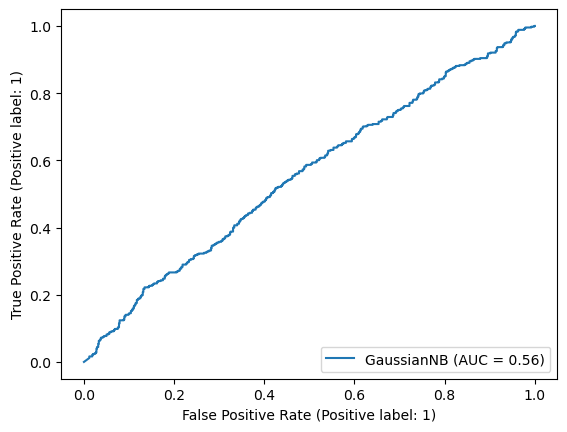

In [12]:
from sklearn.naive_bayes import GaussianNB  # For Gaussian Naive Bayes
models.append(classify(df,0.2,GaussianNB(),"Gaussian Naive Bayes"))

#### KNN

----------------------------------------------------------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.6444818871103623
roc_auc_score: 0.5235631632783531
precision_score: 0.4129032258064516
f1_score: 0.23272727272727273
----------------------------------------------------------------------------------------------------


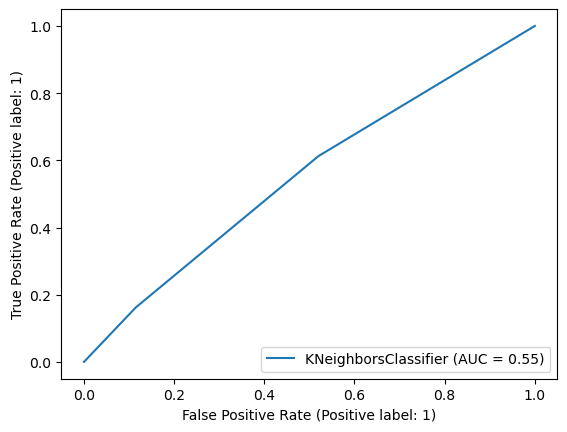

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
models.append(classify(df,0.2,KNeighborsClassifier(2),"KNeighborsClassifier"))

#### AdaBoostClassifier

----------------------------------------------------------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6798652064026959
roc_auc_score: 0.5755250858719523
precision_score: 0.6037735849056604
f1_score: 0.33566433566433573
----------------------------------------------------------------------------------------------------


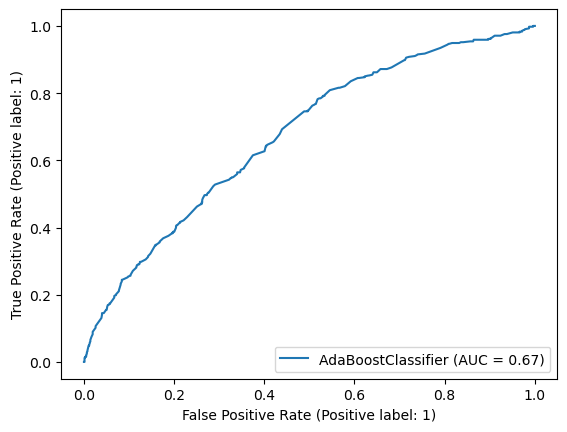

In [14]:
models.append(classify(df,0.2,AdaBoostClassifier(),"AdaBoostClassifier"))

#### CatBoostClassifier

Learning rate set to 0.020032
0:	learn: 0.6907332	total: 48.3ms	remaining: 48.3s
1:	learn: 0.6880611	total: 49.7ms	remaining: 24.8s
2:	learn: 0.6856897	total: 52.1ms	remaining: 17.3s
3:	learn: 0.6833936	total: 53.4ms	remaining: 13.3s
4:	learn: 0.6811006	total: 54.8ms	remaining: 10.9s
5:	learn: 0.6791363	total: 56.4ms	remaining: 9.35s
6:	learn: 0.6769847	total: 58ms	remaining: 8.23s
7:	learn: 0.6751460	total: 59.3ms	remaining: 7.35s
8:	learn: 0.6730962	total: 60.6ms	remaining: 6.67s
9:	learn: 0.6712593	total: 61.8ms	remaining: 6.12s
10:	learn: 0.6694867	total: 63.1ms	remaining: 5.67s
11:	learn: 0.6677248	total: 64.3ms	remaining: 5.3s
12:	learn: 0.6660786	total: 65.5ms	remaining: 4.97s
13:	learn: 0.6646006	total: 66.7ms	remaining: 4.7s
14:	learn: 0.6630601	total: 67.9ms	remaining: 4.46s
15:	learn: 0.6617054	total: 69.2ms	remaining: 4.25s
16:	learn: 0.6603934	total: 70.5ms	remaining: 4.08s
17:	learn: 0.6591350	total: 72ms	remaining: 3.93s
18:	learn: 0.6577590	total: 73.3ms	remaining: 3.79

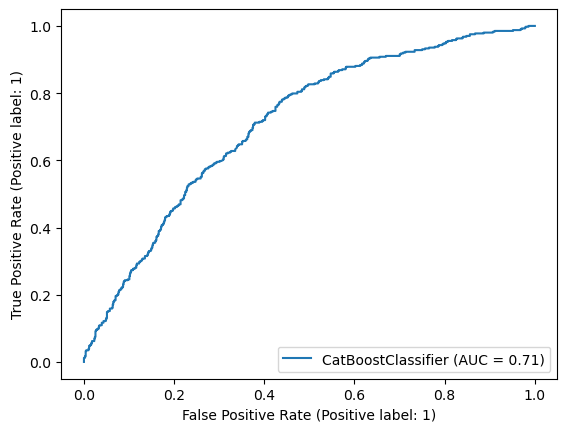

In [15]:
models.append(classify(df,0.2,CatBoostClassifier(),"CatBoostClassifier"))

#### XGBOOST

----------------------------------------------------------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.645324347093513
roc_auc_score: 0.5889949050486336
precision_score: 0.5060975609756098
f1_score: 0.4409030544488711
----------------------------------------------------------------------------------------------------


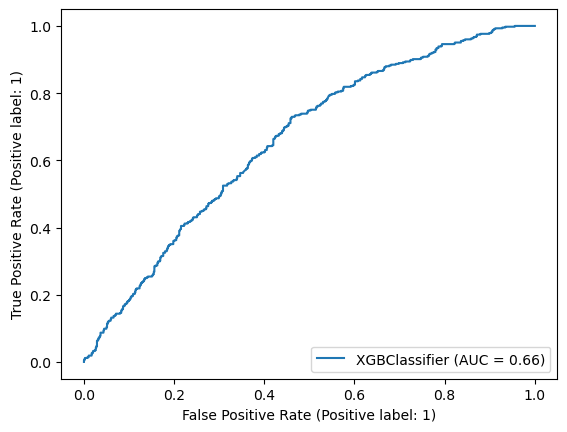

In [16]:
models.append(classify(df,0.2,XGBClassifier(),"XGBClassifier"))

#### LGBM

[LightGBM] [Info] Number of positive: 1664, number of negative: 3082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 4746, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350611 -> initscore=-0.616354
[LightGBM] [Info] Start training from score -0.616354
----------------------------------------------------------------------------------------------------
Model name: LGBMClassifier
accuracy_score: 0.6647009267059815
roc_auc_score: 0.5852101110020388
precision_score: 0.5192307692307693
f1_score: 0.40419161676646703
----------------------------------------------------------------------------------------------------


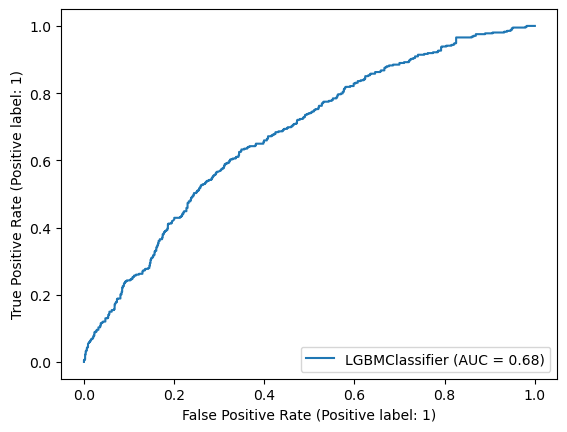

In [17]:
models.append(classify(df,0.2,LGBMClassifier(),"LGBMClassifier"))

#### Comparision

In [50]:
%matplotlib inline
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])
    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    print(model_score)


compare_model_results(models)

                        Accuracy  Precision  Recall      F1
XGBClassifier             0.6453     0.5061  0.3906  0.4409
decision tree             0.6083     0.4469  0.4289  0.4377
logistic regression       0.6967     0.5378  0.3386  0.4156
basic random forrest      0.6655     0.5756  0.3164  0.4083
LGBMClassifier            0.6647     0.5192  0.3309  0.4042
Gaussian Naive Bayes      0.5687     0.3995  0.3902  0.3948
CatBoostClassifier        0.6790     0.5539  0.2804  0.3723
AdaBoostClassifier        0.6799     0.6038  0.2324  0.3357
KNeighborsClassifier      0.6445     0.4129  0.1620  0.2327
Support vector machine    0.6698     0.5849  0.0773  0.1366
